# 🏺 Farsi Handwriting Recognition (OCR) using CRNN

**Project Overview:**
This notebook implements an Optical Character Recognition (OCR) system specifically tailored for **Farsi (Persian)** handwriting. 

**The Challenge:**
Farsi is a cursive script written from **Right-to-Left**, where characters change shape based on their position in a word (initial, medial, final, isolated). Standard computer vision models often struggle with these context-dependent shapes.

**The Solution:**
We use a **CRNN (Convolutional Recurrent Neural Network)** architecture. This combines:
1.  **CNNs** to extract visual features (edges, curves, dots).
2.  **RNNs (LSTMs)** to understand the sequence and context of characters.
3.  **CTC Loss** to handle the alignment between the image and the text without needing segmented character boxes.

CELL 1: Imports AND Config

In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# CONFIG
BATCH_SIZE = 64
IMG_WIDTH = 128
IMG_HEIGHT = 32
MAX_LABEL_LENGTH = 16
CSV_PATH = r"../Shotor/Shotor_Words.csv"
IMG_FOLDER = r"../Shotor/Shotor_Images/"

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


CELL 2: Preprocessing Utils

## 🛠️ Data Preprocessing Pipeline

To prepare the Farsi images for the model, we perform the following steps:

1.  **Vocabulary Construction:** We scan the dataset to build a vocabulary of all unique Farsi characters present (including special characters like 'پ', 'چ', 'ژ', 'گ').
2.  **Image Resizing with Padding:** Unlike standard resizing which distorts aspect ratio, we use `resize_with_pad`. This preserves the shape of the handwriting, which is critical for recognition.
3.  **Grayscale Conversion:** We convert images to single-channel (grayscale) to reduce computational complexity.
4.  **Matrix Transposition:** The image dimensions are swapped from `[Height, Width]` to `[Width, Height]`. This is because the RNN needs to "scan" the image column-by-column across the time axis.
5.  **Label Encoding:** Text labels are converted into sequences of integers using a `StringLookup` layer.

In [10]:
def load_data(csv_path, img_folder):
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Construct Full Image Paths
    df["full_path"] = df['image'].apply(lambda x: os.path.join(img_folder, x))
    
    # Clean Labels (Ensure they are strings)
    df['word'] = df['word'].astype(str)
    
    # Build Vocabulary (including space and special Persian chars)
    all_chars = set()
    for text in df['word'].values:
        all_chars.update(text)
        
    # Sort vocab for consistency
    vocab = sorted(list(all_chars))
    print(f"📊 Dataset Size: {len(df)}")
    print(f"🔤 Unique Characters: {len(vocab)}")
    print(f"Examples: {vocab[:10]}") # Print first few chars to verify
    
    return df, vocab

df, vocab = load_data(CSV_PATH, IMG_FOLDER)

# Create Mappings
char_to_num = layers.StringLookup(vocabulary=vocab, mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

📊 Dataset Size: 120000
🔤 Unique Characters: 35
Examples: [' ', 'آ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ']


In [11]:
import cv2

# Filter Missing Files
df = df[df["full_path"].apply(os.path.exists)]
print(f"Valid files found: {len(df)}")

# Define the Processor
def process_sample(img_path, label):
    def load_tiff_wrapper(path):
        path = path.decode('utf-8')
        img = cv2.imread(path, 0) # Read as Grayscale
        if img is None:
            img = np.zeros((32, 128), dtype=np.uint8)
        img = np.expand_dims(img, axis=-1)
        return img

    # Wrap python function
    img = tf.numpy_function(load_tiff_wrapper, [img_path], tf.uint8)
    img.set_shape([None, None, 1]) # Essential for shape inference

    # Standard TF ops
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    img = tf.transpose(img, perm=[1, 0, 2]) # Transpose for Time-Major RNN
    
    # Label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

# Build the Dataset Pipeline
# Create basic dataset from paths/labels
dataset = tf.data.Dataset.from_tensor_slices((df['full_path'].values, df['word'].values))

# Map the processing function
dataset = dataset.map(process_sample, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and Pad
dataset = dataset.padded_batch(
    BATCH_SIZE, 
    padded_shapes={
        "image": [IMG_WIDTH, IMG_HEIGHT, 1], 
        "label": [None] 
    },
    padding_values={
        "image": 0.0, 
        "label": tf.constant(99, dtype=tf.int64)
    }
)

# Shuffle and Split
dataset = dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_size = int(0.9 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

print(f"Train Batches: {len(train_ds)}")
print(f"Val Batches: {len(val_ds)}")

Valid files found: 120000
Train Batches: 1687
Val Batches: 188


CELL 3: CTC Layer & Model Architecture

## 🧠 Model Architecture: The CRNN

We utilize a hybrid architecture designed for sequence recognition:

### 1. Convolutional Block ( The "Eyes")
* **Layers:** Two `Conv2D` layers followed by `MaxPooling`.
* **Purpose:** These layers act as feature extractors. They look at the raw pixels and identify strokes, dots (*nokteh*), and curves that make up Farsi letters.

### 2. Recurrent Block (The "Brain")
* **Layers:** Two `Bidirectional LSTM` layers.
* **Purpose:** Farsi is cursive; the identity of a letter often depends on its neighbors. The Bidirectional LSTM looks at the sequence both forwards and backwards to understand this context.

### 3. The Output Layer (CTC)
* **Layer:** `CTCLayer` (Connectionist Temporal Classification).
* **Purpose:** Traditional classifiers need one label per image. Since our images contain whole words (sequences), CTC allows the model to predict a sequence of characters where the alignment between the image pixels and the text characters is unknown.

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        padding_token = 99
        label_length = tf.math.count_nonzero(
            tf.not_equal(y_true, padding_token), 
            axis=-1, 
            keepdims=True
        )
        label_length = tf.cast(label_length, dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [13]:
def build_model():
    # Input: (Width, Height, 1) -> Time, Features, Channels
    input_img = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # CNN Block
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool2")(x)

    # Reshape for RNN: (Width/4, Height/4 * 64)
    # We collapse Height and Channels into "Features"
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN Block (Bidirectional LSTM)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output (Vocab + 1 for blank token)
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense_out")(x)

    # CTC Layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = models.Model(inputs=[input_img, labels], outputs=output, name="Persian_CRNN")
    model.compile(optimizer=tf.keras.optimizers.Adam())
    return model

model = build_model()
model.summary()

Model: "Persian_CRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool1               │ (None, 64, 16,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 64, 16,    │     18,496 │ Pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool2               │ (None, 32, 8, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Reshape (Reshape)   │ (None, 32, 512)   │          0 │ Pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ Reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64)    │          0 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 32, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 32, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_out (Dense)   │ (None, 32, 37)    │      4,773 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 37)    │          0 │ label[0][0],      │
│                     │                   │            │ dense_out[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 418,405 (1.60 MB)

 Trainable params: 418,405 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

CELL 4: Training

## 🚀 Training Configuration

* **Optimizer:** `Adam` (Adaptive Moment Estimation) - chosen for its fast convergence.
* **Loss Function:** `CTC Loss` - minimizes the error between the predicted sequence probability and the ground truth text.
* **Callbacks:** `EarlyStopping` is used to prevent overfitting. If the validation loss stops improving for 3 consecutive epochs, training halts automatically.

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/10


2026-01-03 21:07:54.301178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 515 of 1000
2026-01-03 21:08:03.597356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2026-01-03 21:08:03.648020: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1294.4209

2026-01-03 21:09:28.801539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 526 of 1000
2026-01-03 21:09:37.711573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 141s 67ms/step - loss: 1193.7333 - val_loss: 1045.6973
Epoch 2/10


2026-01-03 21:10:09.739549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 524 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:09 42ms/step - loss: 1015.7023  

2026-01-03 21:10:18.683909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 872.9687

2026-01-03 21:11:39.717098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 526 of 1000
2026-01-03 21:11:48.677105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 131s 67ms/step - loss: 779.6112 - val_loss: 530.7010
Epoch 3/10


2026-01-03 21:12:21.021679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 524 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:13 44ms/step - loss: 578.1152  

2026-01-03 21:12:30.060568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 493.8204

2026-01-03 21:13:52.304761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 526 of 1000
2026-01-03 21:14:01.280443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 133s 67ms/step - loss: 462.4030 - val_loss: 332.9093
Epoch 4/10


2026-01-03 21:14:33.675258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 525 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:09 41ms/step - loss: 335.3596  

2026-01-03 21:14:42.778367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 326.1778

2026-01-03 21:16:04.735596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 525 of 1000
2026-01-03 21:16:13.783745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 320.6882 - val_loss: 216.8225
Epoch 5/10


2026-01-03 21:16:45.954290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 528 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:14 44ms/step - loss: 244.3348  

2026-01-03 21:16:54.895554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 244.8525

2026-01-03 21:18:16.564437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 527 of 1000
2026-01-03 21:18:25.536369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 246.5576 - val_loss: 161.8267
Epoch 6/10


2026-01-03 21:18:57.945428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 522 of 1000


   2/1687 ━━━━━━━━━━━━━━━━━━━━ 1:24 50ms/step - loss: 201.9097  

2026-01-03 21:19:06.991077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 193.1825

2026-01-03 21:20:28.682809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 526 of 1000
2026-01-03 21:20:37.640776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 197.6320 - val_loss: 121.7813
Epoch 7/10


2026-01-03 21:21:09.753669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 531 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:15 45ms/step - loss: 108.7443 

2026-01-03 21:21:18.585701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 162.3993

2026-01-03 21:22:40.515479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 530 of 1000
2026-01-03 21:22:49.404043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 167.1989 - val_loss: 97.2135
Epoch 8/10


2026-01-03 21:23:21.673664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 531 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:11 43ms/step - loss: 103.0086 

2026-01-03 21:23:30.501055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 140.0099

2026-01-03 21:24:52.660450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 527 of 1000
2026-01-03 21:25:01.618429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 144.8306 - val_loss: 81.2000
Epoch 9/10


2026-01-03 21:25:33.775440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 532 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:16 46ms/step - loss: 112.2037  

2026-01-03 21:25:42.588373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 120.4953

2026-01-03 21:27:05.259044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 532 of 1000
2026-01-03 21:27:14.150133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 126.8969 - val_loss: 70.4452
Epoch 10/10


2026-01-03 21:27:46.334820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 523 of 1000


   3/1687 ━━━━━━━━━━━━━━━━━━━━ 1:15 45ms/step - loss: 90.2783  

2026-01-03 21:27:55.364952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1686/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 107.3773

2026-01-03 21:29:17.380387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 527 of 1000
2026-01-03 21:29:26.376955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1687/1687 ━━━━━━━━━━━━━━━━━━━━ 132s 67ms/step - loss: 112.8544 - val_loss: 63.1083


In [15]:
prediction_model = models.Model(
    model.get_layer(name="image").output, 
    model.get_layer(name="dense_out").output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Greedy search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :MAX_LABEL_LENGTH]
    
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

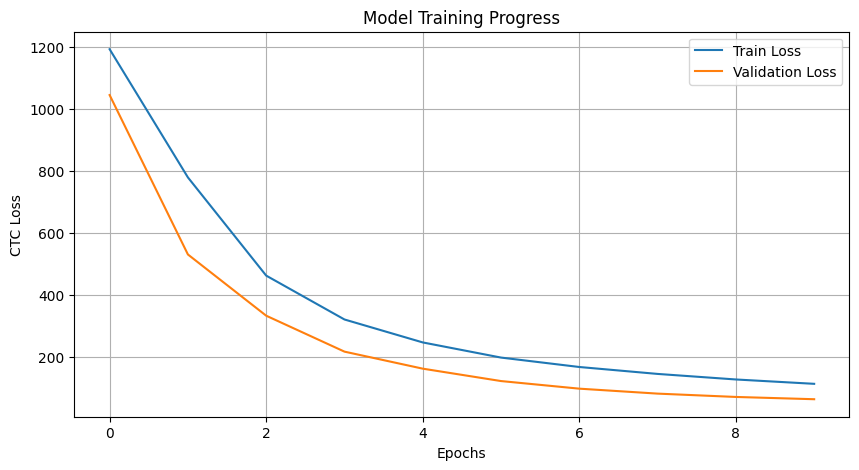

In [16]:
import matplotlib.pyplot as plt  # noqa: F811

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Progress')
    plt.xlabel('Epochs')
    plt.ylabel('CTC Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run this after training finishes
plot_loss(history)

## 🔮 Inference and Decoding

The model outputs a matrix of probabilities for every time-step in the image. To convert this back into readable Farsi text, we use **CTC Decoding**:

1.  **Greedy Search:** At each time step, we take the character with the highest probability.
2.  **Collapse Repeats:** CTC often predicts the same character across multiple time steps (e.g., "aa-l-ii"). The decoder collapses these into a single character ("ali") and removes the special "blank" tokens used by CTC.
3.  **Number to Char:** Finally, the integer sequences are mapped back to their corresponding Farsi Unicode characters.

2026-01-03 21:29:58.672951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 534 of 1000
2026-01-03 21:30:07.320430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step 


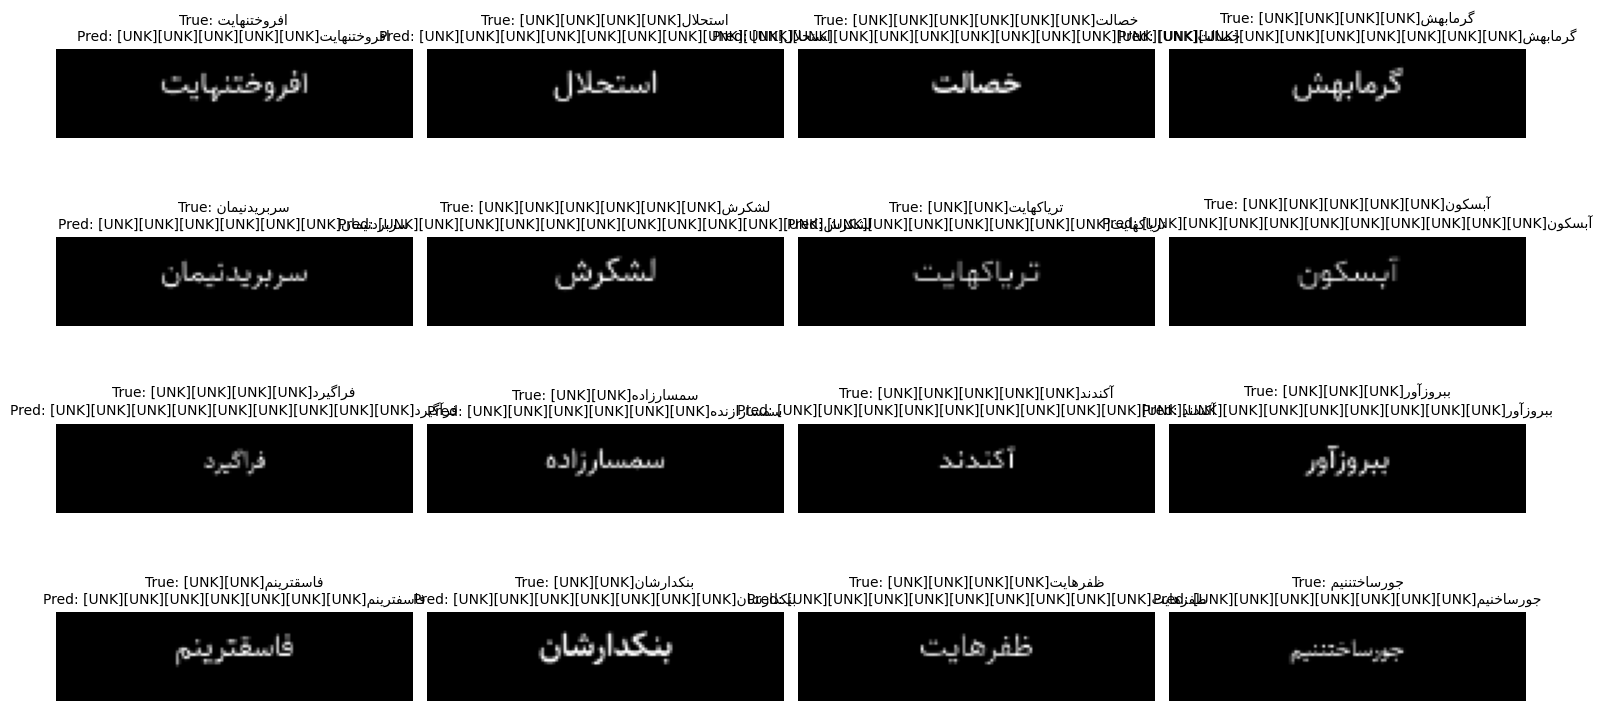

In [17]:
import arabic_reshaper
from bidi.algorithm import get_display

def rtl(text):
    return get_display(arabic_reshaper.reshape(text))


# Visualize a batch
def show_predictions(dataset):
    for batch in dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        fig, ax = plt.subplots(4, 4, figsize=(15, 8))
        for i in range(16):
            img = tf.transpose(batch_images[i], perm=[1, 0, 2])
            img = (img[:, :, 0] * 255).numpy().astype(np.uint8)

            ax[i // 4, i % 4].imshow(img, cmap="gray")

            title = f"True: {rtl(orig_texts[i])}\nPred: {rtl(pred_texts[i])}"
            ax[i // 4, i % 4].set_title(title, fontsize=10)
            ax[i // 4, i % 4].axis("off")

        plt.tight_layout()
        plt.show()


# Run this
show_predictions(val_ds)


In [18]:
import json

# Save the Inference Model
# We save 'prediction_model'
# because we don't need the CTC Loss layer for real-world use.
prediction_model.save("persian_ocr_model.keras")

# Save the Vocabulary
# 'vocab' is the list of characters created in the 'load_data' function
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab, f)

print("Files saved: persian_ocr_model.keras and vocab.json")

Files saved: persian_ocr_model.keras and vocab.json
